In [2]:
## imports
## see environment.yml 

import dask
import fsspec
import gc
import glob
import intake
import requests

import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

from collections import defaultdict
from __future__ import print_function
from matplotlib import pyplot as plt
from params import allnames
import gc
import glob
import dask
import fsspec
import intake


import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl

from collections import defaultdict
from matplotlib import pyplot as plt

from dask.diagnostics import progress
import noresmfunctions as fct
from scipy.stats import norm
from tqdm.autonotebook import tqdm
import xml.etree.ElementTree as ET

from params import allnames
from params import homedir
from params import experiment_ids, years, table_ids, labels, variables, savepath

figdir = homedir + 'figures/'


import xml.etree.ElementTree as ET

from dask.diagnostics import progress
from scipy.stats import norm
from tqdm.autonotebook import tqdm

import noresmfunctions as fct
from myfunctions import process_variable
from myfunctions import drop_all_bounds, open_dset, open_delayed, get_lat_name, global_mean, snotel_pipe

from params import allnames, experiment_ids, variables, years, table_ids, labels
from params import homedir, savepath

## ## style ## ##
xr.set_options(display_style='html')
plt.style.use('./science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False


ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/c/cowherd/.conda/envs/e3smeval/share/proj failed
/tmp/ipykernel_15671/1685443202.py:39: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
snotelmeta = pd.read_csv(homedir + 'data/snotelmeta.csv')

In [4]:
## MASKS AND COORDS ## 
tmp = xr.open_dataset(savepath + 'snw_ACCESS-CM2_historical.nc')
coord = [tmp['lat'],tmp['lon']]
landmask = xr.open_dataset(savepath + 'land_mask.nc')['mask'][0]
sftgif = xr.open_dataset(savepath + 'sftgif_rg.nc')
pct = sftgif['sftgif'][0][0]
icemask = pct < 5
landicemask = (icemask.values & landmask.values)

In [5]:
xr.open_dataset(savepath + 'snw_GFDL-CM4_historical.nc')


<xarray.Dataset>
Dimensions:         (time: 1980, lat: 160, lon: 320, bnds: 2)
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id       object ...
    dcpp_init_year  float64 ...
  * lat             (lat) float64 -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon             (lon) float64 -180.0 -178.9 -177.8 ... 176.6 177.8 178.9
Data variables:
    snw             (time, lat, lon) float32 ...
Attributes: (12/62)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:variable_id:     snw
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM...
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.LImo...

In [17]:
for variable in variables:
    for experiment_id in experiment_ids:
        process_variable(variable, experiment_id)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_BCC-CSM2-MR_ssp585.nc is downloaded
Have regridded in total: 1 files
tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_GFDL-ESM4_ssp585.nc is downloaded
Have regridded in total: 2 files
tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_GFDL-CM4_ssp585.nc is downloaded
Have regridded in total: 3 files


/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


tas True
could not compute tas for IPSL-CM6A-LR
tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_ACCESS-CM2_ssp585.nc is downloaded
Have regridded in total: 4 files
tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_MRI-ESM2-0_ssp585.nc is downloaded
Have regridded in total: 5 files
could not compute tas for CESM2-WACCM
tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_UKESM1-0-LL_ssp585.nc is downloaded
Have regridded in total: 6 files
tas True
/global/cfs/cdirs/e3sm/cowherd/data/april25/tas_MIROC6_ssp585.nc is downloaded
Have regridded in total: 7 files


In [16]:
scenarios = ['historical', 'ssp245', 'ssp585']
variables = ['snw', 'pr', 'tas']
datasets_3m_sum_maxsnw = {}
datasets_3m_sum = {}
swei_datasets = {}
swei_datasets_maxsnw = {}
categs = {}

for model in allnames2:
    filenames = [f"{savepath}{var}_{model}_{scen}.nc" for var in variables for scen in scenarios]
    datasets = {filename.split('/')[-1].split('.')[0]: xr.open_dataset(filename) for filename in filenames}
    for name, ds in datasets.items():
        datasets_3m_sum[name] = get_3m_sum(ds)

    for scen in scenarios[1:3]:
        ds_s = datasets[f'snw_{model}_{scen}']
        ds_h = datasets[f'snw_{model}_historical']
        ds_long = xr.concat([ds_h, ds_s], dim = 'time')
        swei_datasets[f'{model}_{scen}'] = get_swei(ds_long)

    for name, ds in datasets_3m_sum.items():
        var = name.split('_')[0]
        snw_ds = datasets_3m_sum[f'snw_{name.split(f"{var}_")[-1]}']
        datasets_3m_sum_maxsnw[name] = collapse_to_highest_month(ds, var, snw_ds, True)

    for name, ds in swei_datasets.items():
        var = 'swei'
        scen = name.split('_')[-1]
        snw_s = datasets_3m_sum[f'snw_{model}_{scen}']
        snw_h = datasets_3m_sum[f'snw_{model}_historical']
        snw_long = xr.concat([ds_h, ds_s], dim = 'time')
        tmp = collapse_to_highest_month(ds, var, snw_long, False)
        tmp.to_netcdf(f'{savepath}swei_max_{name}.nc')
        swei_datasets_maxsnw[f'{model}_{scen}'] = tmp

    for name, swei in swei_datasets_maxsnw.items():
        scen = name.split('_')[-1]
        pr_h = datasets_3m_sum_maxsnw[f'pr_{model}_historical']
        pr_s = datasets_3m_sum_maxsnw[f'pr_{model}_{scen}']
        pr_long = xr.concat([pr_h, pr_s], dim = 'year')
        pr_anom = pr_long - pr_long.sel(year=slice(pr_long.year[0], pr_long.year[49])).mean(dim='year') ## val minus average

        tas_h = datasets_3m_sum_maxsnw[f'tas_{model}_historical']
        tas_s = datasets_3m_sum_maxsnw[f'tas_{model}_{scen}']
        tas_long = xr.concat([tas_h, tas_s], dim = 'year')
        tas_anom = tas_long - tas_long.sel(year=slice(tas_long.year[0], tas_long.year[49])).mean(dim='year') ## val minus average

        tmp = get_sd_categ(swei, pr_anom ,tas_anom, pr_long.attrs)
        try:
            tmp.to_netcdf(f'{savepath}categs_{name}.nc')
        except:
            continue
        categs[name] = tmp
        


['ACCESS-CM2',
 'BCC-CSM2-MR',
 'CESM2-WACCM',
 'GFDL-ESM4',
 'GFDL-CM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [1]:
datasets

NameError: name 'datasets' is not defined

In [2]:
## mask and compute inter-model means ## 
for variable in variables:
    for experiment_id in experiment_ids:
        fns = glob.glob(savepath + f'{variable}*12_{experiment_id}*')
        datasets = xr.open_mfdataset(fns, combine='nested', concat_dim='source_id')
        model_mean = datasets.mean(dim='source_id')
        if variable == 'snw':
            num_years = len(model_mean['time']) // 12
            low_snw = model_mean['snw'] < 0.1
            low_snw_count = low_snw.sum(dim='time')
            low_snw_avg = low_snw_count / num_years
            mask = low_snw_avg > 1
            model_mean_masked = model_mean.where(mask).drop('bnds')
            mask2 = low_snw_count < 1700
            model_mean_masked2 = model_mean_masked.where(mask2)
            nc_out = savepath +f'{variable}_model_mean_{experiment_id}.nc'
            model_mean_masked2.to_netcdf(nc_out)
        else:
            nc_out = savepath +f'{variable}_model_mean_{experiment_id}.nc'
            model_mean.to_netcdf(nc_out)
        print(f'saved {nc_out}')

saved /global/cfs/cdirs/e3sm/cowherd/data/april25/snw_model_mean_historical.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/snw_model_mean_ssp245.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/snw_model_mean_ssp585.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/tas_model_mean_historical.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/tas_model_mean_ssp245.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/tas_model_mean_ssp585.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/pr_model_mean_historical.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/pr_model_mean_ssp245.nc
saved /global/cfs/cdirs/e3sm/cowherd/data/april25/pr_model_mean_ssp585.nc


In [3]:
## compute swei on the masked intermodel mean, to visualize, not to use for actual analysis ## 
for experiment_id in experiment_ids:
    snw_data = xr.open_dataset(savepath + f'snw_model_mean_{experiment_id}.nc')
    swei = get_swei(snw_data['snw'])
    da_filled = snw_data.drop('time').fillna(-999)
    da_filled.coords['month'] = da_filled.time%12
    da_filled.coords['year'] = da_filled.time%165
    da_filled = da_filled.swap_dims({'time':'month'})
    maxmonth = np.nanargmax(da_filled['snw'].data.reshape(-1,12,160,320),axis=1).astype(int)
    i, j = np.meshgrid(np.arange(swei.shape[2]), np.arange(swei.shape[3]), indexing='ij')
    swei_maxmonth = swei[:,maxmonth, i, j]
    np.save(savepath + f'swei_imm_{experiment_id}',swei_maxmonth)
    
    

In [200]:
## compute swei for all data sets separately (after regridding), for saving and analysis ##
for model_id in allnames:
    if model_id != 'IPSL-CM6A-LR':
        hist = xr.open_dataset(glob.glob(savepath + f'snw_{model_id}*_historical.nc')[0])
        ssp245 = xr.open_dataset(glob.glob(savepath + f'snw_{model_id}*_ssp245.nc')[0])
        ssp585 = xr.open_dataset(glob.glob(savepath + f'snw_{model_id}*_ssp585.nc')[0])
        long245 = xr.concat([hist,ssp245],dim = 'time')
        swei245 = get_swei(long245['snw'])
        long585 = xr.concat([hist,ssp585],dim = 'time')
        swei585 = get_swei(long585['snw'])
        #da_filled = hist.drop('time').fillna(-999)
        #da_filled.coords['month'] = da_filled.time%12
        #da_filled.coords['year'] = da_filled.time%165
        #da_filled = da_filled.swap_dims({'time':'month'})
        #maxmonth = np.nanargmax(da_filled['snw'].data.reshape(-1,12,160,320),axis=1).astype(int)
        #i, j = np.meshgrid(np.arange(swei245.shape[2]), np.arange(swei245.shape[3]), indexing='ij')
        #
        #swei_maxmonth_245 = swei245[:,maxmonth, i, j]
        #swei_maxmonth_585 = swei585[:,maxmonth, i, j]
        #
        np.save(savepath + f'swei_{model_id}_ssp245',swei245)
        np.save(savepath + f'swei_{model_id}_ssp585',swei585)
        #
        print(f'saved all experiments for {model_id}')

        

saved all experiments for ACCESS-CM2
saved all experiments for BCC-CSM2-MR
saved all experiments for CESM2-WACCM
saved all experiments for GFDL-ESM4
saved all experiments for GFDL-CM4
saved all experiments for MIROC6
saved all experiments for MRI-ESM2-0
saved all experiments for UKESM1-0-LL


In [28]:
model_id = 'ACCESS-CM2'
hist = xr.open_dataset(glob.glob(savepath + f'snw_{model_id}*_historical.nc')[0])
ssp245 = xr.open_dataset(glob.glob(savepath + f'snw_{model_id}*_ssp245.nc')[0])
ssp585 = xr.open_dataset(glob.glob(savepath + f'snw_{model_id}*_ssp585.nc')[0])
long245 = xr.concat([hist,ssp245],dim = 'time')
swei = np.load(savepath + f'swei_{model_id}_ssp585.npy')

In [ ]:
## PLOTS FOR FIG 2, intermodel means ##

colors = {'historical':'black',
          'ssp245':'darkblue',
          'ssp585':'darkred'}
years = {'historical': [1900.0,2014.0],
          'ssp245':[2014.0,2100.0],
          'ssp585':[2014.0,2100.0]}

snw_anom = 
tas_anom = 
pr_anom = 

anoms = {'snw':snw_anom,
         'tas':tas_anom,
         'pr':pr_anom}

fig,ax= plt.subplots(1,3,figsize = (20,5))
for i,val in enumerate(variables):
    anom = anoms[val]
    anom = anom.to_dataframe().reset_index()
    namesmask = np.array([val in allnames for val in anom.source_id])
    anom = anom[namesmask]# .loc[anom.to_dataframe().reset_index() ['source_id']  != 'ACCESS-CM2']
    grouped = anom.groupby(['experiment_id','year']).mean()
    grouped_sd = anom.groupby(['experiment_id','year']).std()
    for exp in experiment_ids:
        y1 = years[exp][0]
        y2 = years[exp][1]
        data = grouped.loc[exp][y1:y2]
        sd = grouped_sd.loc[exp][y1:y2]
        ax[i].plot(data, color = colors[exp],label = exp)
        ax[i].fill_between(data.index, data[val]- sd[val], data[val] + sd[val], color = colors[exp], alpha = 0.3)
    ax[i].set_ylabel(r'$\Delta$ ' + val)
ax[0].legend(loc = 'lower left', frameon = False)
plt.show()

In [ ]:
fig,ax=plt.subplots()

from scipy.stats import norm
cs = plt.cm.rainbow(np.linspace(0, 1,len(allnames)))

##
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False
##

snhistlines = []
sn245lines = []
sn585lines = []

for i,model in enumerate(allnames):
    data = df_snw[df_snw['source_id'] == model]
    for exp in experiment_ids:
        tmp = data[data.experiment_id == exp]
        if exp == 'historical': mv = np.nanmean(tmp.snw)
        nsnw = (tmp.snw -mv)/mv
        nsnw = nsnw.reset_index().snw
        if exp == 'historical':
            ax.plot(tmp.year, nsnw, c=cs[i],label = model) #, c = colors[model], label = model)
        else:
            ax.plot(tmp.year, nsnw, c=cs[i]) # , c = colors[model])
        if exp == 'historical': snhistlines.append(nsnw)
        if exp == 'ssp245': sn245lines.append(nsnw)
        if exp == 'ssp585': sn585lines.append(nsnw)
ax.legend(loc = 'lower left', ncol = 2, frameon = False)
ax.set_ylabel('normalized SWE anomaly')
plt.show()

sn245m = np.nanmean(np.array(pd.DataFrame(sn245lines)),axis=0)
sn245sd = np.nanstd(np.array(pd.DataFrame(sn245lines)),axis=0)
sn585m = np.nanmean(np.array(pd.DataFrame(sn585lines)),axis=0)
sn585sd = np.nanstd(np.array(pd.DataFrame(sn585lines)),axis=0)
years = range(1900,2101)
hyears = range(1900,2015)
syears = range(2015,2100)
fig,ax= plt.subplots(figsize = (7,5))
meanhist = np.nanmean(np.array(pd.DataFrame(snhistlines)),axis=0)
sdhist =np.nanstd(np.array(pd.DataFrame(snhistlines)),axis=0)
ax.plot(years, meanhist, colors['historical'], label = 'historical')
ax.fill_between(years, meanhist- sdhist, meanhist +sdhist, color = colors['historical'], alpha = 0.3)
data = sn245m
sd = sn245sd
ax.plot(years, sn245m,colors['ssp245'], label = 'SSP 245')
ax.fill_between(years, data -sd, data + sd, color = colors['ssp245'], alpha = 0.3)
data = sn585m
sd = sn585sd
ax.plot(years, data,colors['ssp585'], label = 'SSP 585')
ax.fill_between(years, data - sd, data +sd, color = colors['ssp585'], alpha = 0.3)
ax.legend(loc = 'lower left', frameon = False)
ax.set_ylabel('normalized SWE anomaly')
plt.show()


18


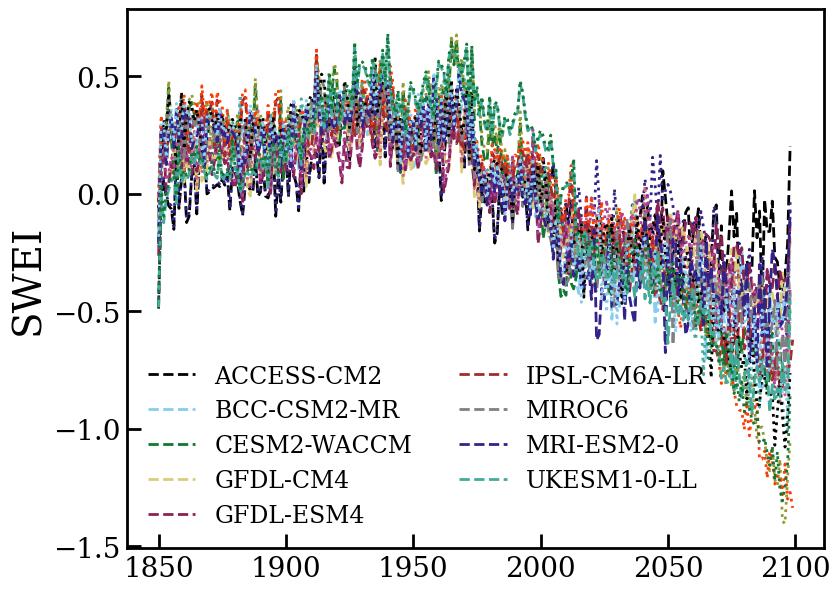

In [5]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False

import glob
fig,ax= plt.subplots(figsize = (9,7))
files = glob.glob('/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_[!imm]*')
print(len(files))
styles = {'585':':',
          '245':'--'}
s245lines = []
s585lines = []
years = range(1851, 2100)
for fn in sorted(files):
    model = fn.split('_')[-2]
    if model in allnames:
        era = fn.split('ssp')[-1][0:3]
        sweidata = np.load(fn)
        clipmean = np.nanmean(sweidata[:,:,35:,:],axis=(1,2,3)).flatten()
        years = range(1850, 1850 + len(clipmean))
        if era == '585': label = None
        else: label = model
        kwargs = {'linestyle':styles[era], 'label':label} #'c':colors[model], 'label': label}
        ax.plot(years, clipmean, **kwargs)
        if era == '585':
            s585lines.append(clipmean)
        if era == '245':
            s245lines.append(clipmean)
            
ax.legend(loc = 'lower left', frameon = False, ncol = 2)
ax.tick_params(direction="in")
ax.set_ylabel('SWEI')
plt.show()


In [320]:
s245arr = np.zeros((9,249))
for i,val in enumerate(s245lines):
    while len(val) > 249: val = val[1:]
    s245arr[i,:] = val
s585arr = np.zeros((9,249))
for i,val in enumerate(s585lines):
    while len(val) > 249: val = val[1:]
    s585arr[i,:] = val

In [323]:

##
s245m = np.nanmean(s245arr, axis = 0)
s245sd = np.nanstd(s245arr, axis = 0)
s585m = np.nanmean(s585arr, axis = 0)
s585sd = np.nanstd(s585arr, axis = 0)
years = range(1850,2100)
hyears = range(1851,2015)
syears = range(2015,2097)
base245 = np.nanmean(s245m[1:51])
base585 = np.nanmean(s585m[1:51])
##

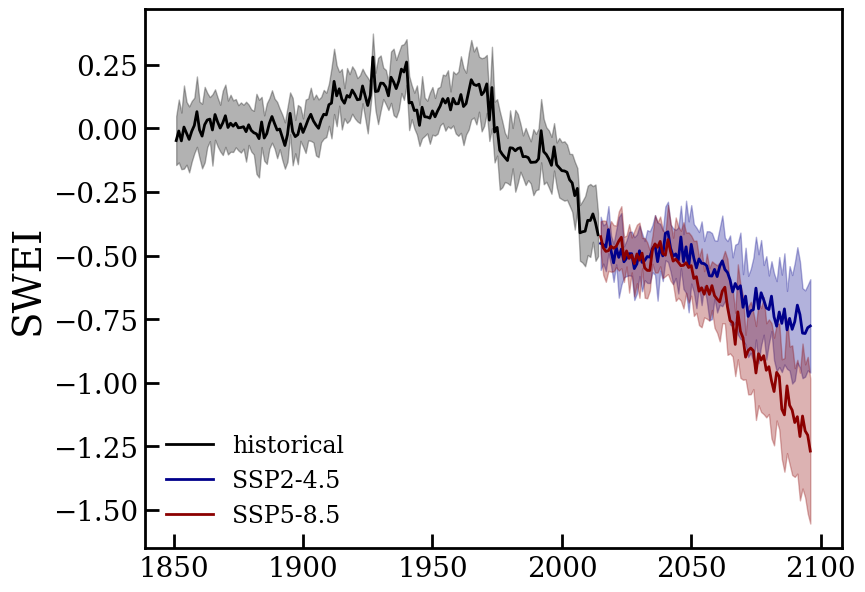

In [325]:
from params import colors
fig,ax= plt.subplots(figsize = (9,7))
meanhist = (s245m[1:165]-base245 + s585m[1:165]-base585)/2
sdhist = (s245sd[1:165]+ s585sd[1:165])/2
ax.plot(hyears,meanhist, colors['historical'], label = 'historical')
ax.fill_between(hyears,meanhist- sdhist, meanhist +sdhist, color = colors['historical'], alpha = 0.3)
data = s245m[165:-2]-base585
sd = s245sd[165:-2]
ax.plot(syears,s245m[165:-2]-base585,color = colors['ssp245'], label = 'SSP2-4.5')
ax.fill_between(syears, data-sd, data + sd, color = colors['ssp245'], alpha = 0.3)
data = s585m[165:-2]-1.35*base585
sd = s585sd[165:-2]
ax.plot(syears,data,colors['ssp585'], label = 'SSP5-8.5')
ax.fill_between(syears,data - sd, data +sd, color = colors['ssp585'], alpha = 0.3)
ax.legend(loc = 'lower left', frameon = False)
ax.set_ylabel('SWEI')
ax.tick_params(direction="in")
plt.show()
fig.savefig('../figures/fig2.jpg')

In [15]:
### PLOTS FOR FIG 1 ###
## load snotel data from stefan values stuff ##
#SNOTEL
snoteldir = '/global/cfs/cdirs/m4099/fate-of-snotel/snoteldata/'
file = snoteldir + "snotel_daily.txt"

ilat = -999
ilon = -999

rec_min = -70.
rec_max = 60.

ind_time = 0
ind_name = 1
ind_sitecode = 2
ind_state = 3
ind_elev = 4
ind_lat = 5
ind_lon = 6
ind_swe = 7
ind_tav = 8
ind_tmax = 9
ind_tmin = 10
ind_acc = 11
ind_prec = 12

ind_swe_qc = 13
ind_swe_qc = 15

ft2m = 12 * 2.54 / 100.
in2mm = 25.4
p49 = 49.
m100 = -100
T0 = 273.15

#Box to mask outsdie Sierra
lat_l = 35.
lat_u = 41.
lon_l = -122.5
lon_u = -116.5

read = open(file, "r")
content = read.readlines()

lat_snotel = []
lon_snotel = []
state_snotel = []
elev_snotel = []
time_snotel = []
site_snotel = []
prec_snotel = []
acc_snotel = []
swe_snotel = []
tav_snotel = []
tmin_snotel = []
tmax_snotel = []
name_snotel = []

lat_snotel_spec = []
lon_snotel_spec = []
elev_snotel_spec = []
site_snotel_spec = []

bad = -9999999
line_count = 1
lat_orig = -999. 

for line in content:
    
 if line.startswith("#") or line.startswith("Date"):
    continue

 else:
  ii = line.split(",")

  if ii[ind_state] == ii[ind_state]:
    time_snotel.append(ii[ind_time])       #Get times
    site_snotel.append(int(ii[ind_sitecode]))       #Get codes
    lat_snotel.append(float(ii[ind_lat]))
    lon_snotel.append(float(ii[ind_lon]))
    elev_snotel.append(float(ii[ind_elev])*ft2m)
    state_snotel.append(ii[ind_state])

   #SWE
    if ii[ind_swe] == "":
     swe_snotel.append(bad)
    if ii[ind_swe] != "":
     swe_x = float(ii[ind_swe])
     swe_snotel.append(swe_x)

    #Temperature
    #There are strange Tav, Tmin, and Tmax values in the data
    #We use reasonable assumptions to get rid of them
    # 1. If one is missing, eliminate them all
    # 2. Remove instances where Tmax = Tmin, Tmax = Tav, Tmax = Tmin
    # 3. Eliminate *rcords*
    
    switch = "on" #if on, raw SNOTEL data is appended
    
    #1.
    if ii[ind_tav] == "" or ii[ind_tmin] == "" or ii[ind_tmax] == "":
     tav_snotel.append(bad)
     tmax_snotel.append(bad)
     tmin_snotel.append(bad)
     switch = "off"

    if ii[ind_tav] != "" and ii[ind_tmin] != "" and ii[ind_tmax] != "":
     tav = float (ii[ind_tav])
     tmax = float (ii[ind_tmax])
     tmin = float (ii[ind_tmin])

     #2.
     dt1 = tmax - tmin
     dt2 = tmax - tav
     dt3 = tmin - tav
        
     if dt1 < 0 or dt2 < 0 or dt3 > 0:
      if switch == "on":        #This switch ensures no double-dipping
       tav_snotel.append(bad)   #"Just take one dip, and end it!!!"
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)        
       switch = "off"

     #3.
     if tmax < rec_min or tav < rec_min or tmin < rec_min:    
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)
       switch = "off"
    
     if tmax > rec_max or tav > rec_max or tmin > rec_max:
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad) 
       switch = "off"

     if switch == "on":
        tav_snotel.append(tav)
        tmax_snotel.append(tmax)
        tmin_snotel.append(tmin)

    #Acc. precip
    if ii[ind_acc] == "":
     acc_snotel.append(bad)
    if ii[ind_acc] != "":
     acc_x = float(ii[ind_acc])
     acc_snotel.append(acc_x)
    
     #Prec
    if ii[ind_prec] == "" or ii[ind_prec] == "\n":
     prec_snotel.append(bad)
    else:
     prec_mm = float(ii[ind_prec])
     prec_snotel.append(prec_mm)

    #Checks
    if float(ii[ind_lat]) != lat_orig:
     lat_snotel_spec.append(float(ii[ind_lat]))
     lon_snotel_spec.append(float(ii[ind_lon]))
     elev_snotel_spec.append(float(ii[ind_elev])*ft2m)
     site_snotel_spec.append(int(ii[ind_sitecode]))

     lat_orig =  float(ii[ind_lat])
        
snotel_day = pd.to_datetime(time_snotel, format='%Y-%m-%d')

#Convert to DataArray
swe_snotel = xr.DataArray(swe_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
prec_snotel = xr.DataArray(prec_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tave_snotel = xr.DataArray(tav_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmin_snotel = xr.DataArray(tmin_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmax_snotel = xr.DataArray(tmax_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
acc_snotel = xr.DataArray(acc_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel),
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})

#Meta array for all SNOTEL sites
meta_snotel = xr.DataArray(elev_snotel_spec,dims=['site'],coords={'site':( ['site'],site_snotel_spec), 
                                                              'lat':( ['site'],lat_snotel_spec),
                                                              'lon':( ['site'],lon_snotel_spec)})


print (len(lat_snotel_spec), len(lon_snotel_spec), len(elev_snotel_spec), len(site_snotel_spec))

print (prec_snotel)

print ("CONUS SNOTEL array generated")

gc.collect()

111 111 111 111
<xarray.DataArray (x: 577172)>
array([3., 0., 3., ..., 0., 0., 0.])
Coordinates:
    site     (x) int64 308 308 308 308 308 308 308 ... 784 784 784 784 784 784
    time     (x) datetime64[ns] 2019-09-02 2019-09-03 ... 2011-04-29 2011-04-30
    z        (x) float64 2.225e+03 2.225e+03 2.225e+03 ... 2.442e+03 2.442e+03
    state    (x) <U10 'ARIZONA' 'ARIZONA' ... 'CALIFORNIA' 'CALIFORNIA'
    lat      (x) float64 34.46 34.46 34.46 34.46 ... 39.19 39.19 39.19 39.19
    lon      (x) float64 -111.4 -111.4 -111.4 -111.4 ... -120.3 -120.3 -120.3
Dimensions without coordinates: x
CONUS SNOTEL array generated


1535

In [55]:
## load globsnow data
mydir = '/global/cfs/cdirs/e3sm/cowherd/data/'
globsnow = xr.open_dataset(mydir + 'globsnow_no_ak.nc')
globsnow_bc = xr.open_dataset(mydir + 'globsnow_bc_no_ak.nc')
era5 = xr.open_dataset(mydir + 'era5_no_ak.nc')

In [56]:
monthly_e5_mm = np.nanmean(era5.sd.data * 1000, axis =(1,2))
monthly_bc = np.nanmean(globsnow_bc.swe, axis = (1,2))
monthly = np.nanmean(globsnow.swe, axis = (1,2))

In [17]:
monthly_bc =np.array([111.62574958, 193.22927384, 119.6392822 ,  71.65213745])
bc_nums = [2,3,4,5]
monthly_glob = np.array([2.90396489e+01, 3.04059308e+01, 1.84548280e+01, 6.69667089e+00,
       1.52255673e+00, 1.03142754e-02, 2.95057920e-03, 6.33202825e-02,
       1.37616140e+00, 1.18776219e+01])
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]

In [43]:
import datetime


IPSL-CM6A-LR


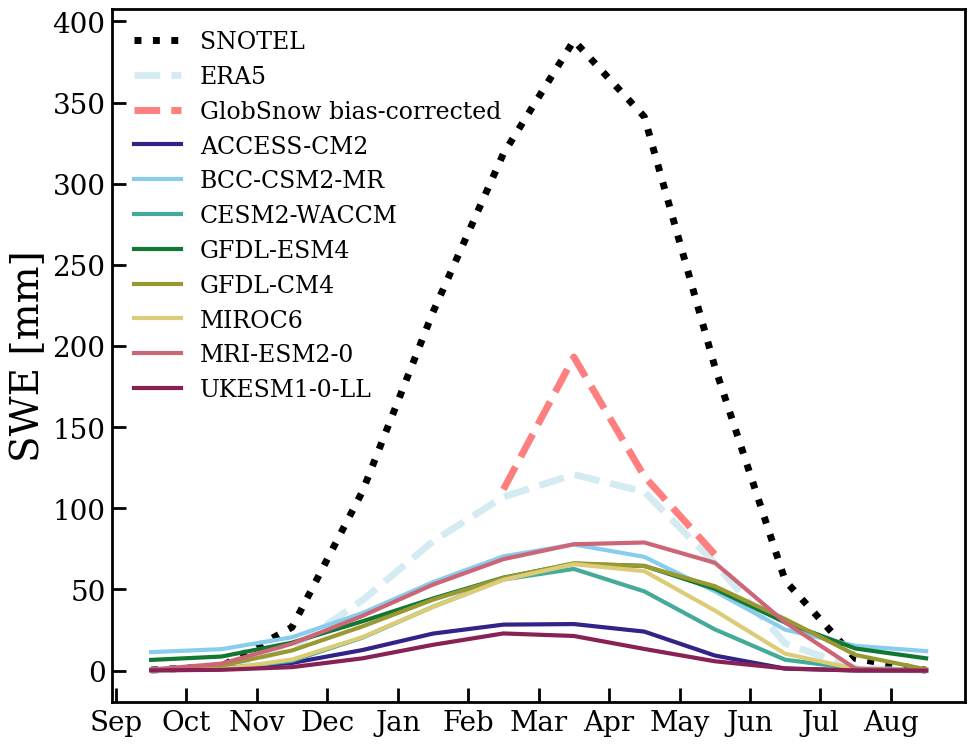

In [68]:
## just the snotel sites ##
months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(snotel_data,4),':', linewidth = 5, alpha = 1, label = 'SNOTEL')
#ax.plot(nums, np.roll(merramonthly,4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')
ax.plot(nums, np.roll(monthly_e5_mm,4), '--', c = "lightblue",linewidth = 5 , alpha = 0.5, label = 'ERA5')
# ax.plot([val + .5 for val in monthly_glob], np.roll(monthly_glob,4), '--', c = "green",linewidth = 5 , alpha = 0.5, label = 'GlobSnow')
ax.plot([5.5,6.5,7.5,8.5], np.roll(monthly_bc,4), '--', c = "red",linewidth = 5 , alpha = 0.5, label = 'GlobSnow bias-corrected')

models_snw_arrs = []
for key in allnames:
    try:
        snw_data = xr.open_dataset(glob.glob(savepath + f'snw_{key}*_historical.nc')[0]) 
        snw_snotel = snw_data.pipe(snotel_pipe)
        snw_snotel_data = []
        for i, row in enumerate(snw_snotel):
            snw_snotel_data.append(row.groupby(row.time.dt.month).mean().data)
        monthly = np.nanmean(np.array(snw_snotel_data),axis=0)
        # models_snw_arrs.append(monthy)
        ax.plot(nums, np.roll(monthly,4), label = key, linewidth = 3)
    except:
        print(key)
data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()
fig.savefig('../figures/fig1_old.jpg')

In [ ]:
## just the snotel sites ##
def minmax(data):
    return [(val- np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) for val in data]


months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(minmax(snotel_data.data),4),':',  linewidth = 5, alpha = 1, label = 'SNOTEL')
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')

for i,key in allnames:
    ax.plot(nums, np.roll(minmax(monthly),4), label = key, linewidth = 3)

ax.plot(nums, np.roll(minmax(snotel_data.data),4),':', color = 'k', linewidth = 5, alpha = 1)
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend(loc = 'upper right', fontsize = 12)
plt.show()

In [72]:
## SUPPLEMENT COULD SHOW SOME DISTRIBUTION OF SNOW DROUGHTS IN THE PAST COMPARED TO HUNING ##
ha_files = glob.glob('/global/cfs/cdirs/e3sm/cowherd/data/GLOBAL_SNOW_DROUGHT_DATA_SET_SWEI/*.nc')
ha_data = xr.open_mfdataset(ha_files, concat_dim = 'time', combine='nested')


/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


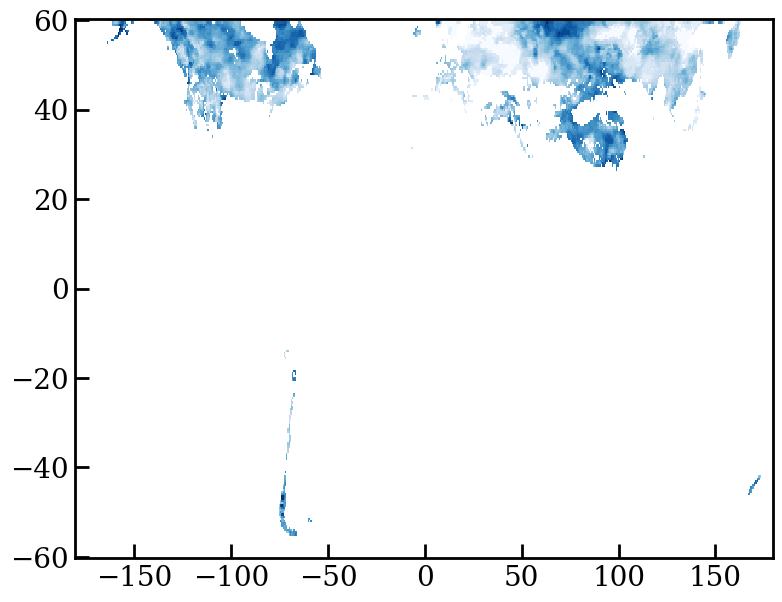

In [137]:
tmp = ha_data.SWEI / ((ha_data['SWEI'] > -10) & (ha_data['SWEI'] < 10)).astype(int)
plt.pcolormesh(ha_data.lon, ha_data.lat, tmp[100,:,:].transpose(), cmap = 'Blues')
plt.show()